# KUONTOL KEJEPIT PROJECT

In [17]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from torchvision import transforms
import os

#optional
import matplotlib.pyplot as plt

## LOAD DATASET

In [24]:
# Load train and validation data
train_df = pd.read_csv('datasets/CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('datasets/CheXpert-v1.0-small/valid.csv')

if 'train_df' in locals() and 'valid_df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [25]:
# Display first 5 rows of validation data
train_df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [20]:
print(train_df.dtypes)

Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
No Finding                    float64
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
dtype: object


In [27]:
# Filter dataset untuk mengambil data dengan No indingF = 1.0
nofinding_filtered0 = train_df[train_df['No Finding'] == 1.0]

# Tampilkan distribusi data dari semua label yang sudah difilter
print("Distribusi Data dari Semua Label (Filtered No Finding = 1.0):")
label_distribution = nofinding_filtered0.iloc[:, 5:].apply(pd.Series.value_counts, dropna=False)
label_distribution

Distribusi Data dari Semua Label (Filtered No Finding = 1.0):


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0.0,NaN,8394.0,3350.0,2421.0,377.0,4461.0,8836.0,1158.0,483.0,13411.0,11450.0,20.0,1091.0,671
1.0,22381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8808
NaN,NaN,13987.0,19031.0,19960.0,22004.0,17920.0,13545.0,21223.0,21898.0,8970.0,10931.0,22361.0,21290.0,12792


In [28]:
# Filter dataset untuk mengambil data dengan No Finding = NaN
nofinding_filtered1 = train_df[pd.isna(train_df['No Finding'])]

# Tampilkan distribusi data dari semua label yang sudah difilter
print("Distribusi Data dari Semua Label (Filtered No Finding = NaN):")
label_distribution = nofinding_filtered1.iloc[:, 5:].apply(pd.Series.value_counts, dropna=False)
label_distribution

Distribusi Data dari Semua Label (Filtered No Finding = NaN):


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,NaN,12403,8087,5598,1488,12984,27742,18770,33739,3145,11628,2653,642,969
0.0,NaN,13244,7766,4178,893,16265,19261,1641,845,42930,23946,296,1421,5466
1.0,NaN,10798,27000,105581,9186,52246,14783,6039,33376,19448,86187,3523,9040,107193
NaN,201033.0,164588,158180,85676,189466,119538,139247,174583,133073,135510,79272,194561,189930,87405


Kesimpulannya adalah<br>
- JIKA `no finding` bernilai `1.0` MAKA pasien tidak memiliki penyakit atau semua penyakit bernilai `0.0` dan `nan`<br>
- JIKA `no finding` bernilai `nan` MAKA pasien memiliki penyakit `[1.0]` atau tidak memiliki penyakit `[0.0, nan]` atau ambigu `[0.5]`

<br>
Tabel dibawah ini menunjukan semua jenis label dan menandai bagian/data yang tidak diperlukan dalam penelitian ini.
<br>
<br>

| **Index**| **Label**                  | **Deskripsi**                              | **Data yang Tidak Diperlukan** |
|----------|----------------------------|--------------------------------------------|---|
| 0        | Path                       | Jalur file gambar X-ray                    |   |
| 1        | Sex                        | Jenis kelamin pasien (Laki-laki/Perempuan) | x |
| 2        | Age                        | Usia pasien                                | x |
| 3        | Frontal/Lateral            | Jenis tampilan X-ray (Frontal/Lateral)     | x |
| 4        | AP/PA                      | Jenis proyeksi (AP/PA/LL/RL)               | x |
| 5        | No Finding                 | Tidak ada kelainan ditemukan               | x |
| 6        | Enlarged Cardiomediastinum | Pembesaran area jantung dan mediastinum    |   |
| 7        | Cardiomegaly               | Pembesaran jantung                         |   |
| 8        | Lung Opacity               | Kekeruhan pada paru-paru                   |   |
| 9        | Lung Lesion                | Lesi atau massa di paru-paru               |   |
| 0        | Edema                      | Cairan berlebih di jaringan paru           |   |
| 11       | Consolidation              | Area padat di paru-paru                    |   |
| 12       | Pneumonia                  | Infeksi paru-paru                          |   |
| 13       | Atelectasis                | Kolaps parsial atau total paru-paru        |   |
| 14       | Pneumothorax               | Udara di rongga pleura                     |   |
| 15       | Pleural Effusion           | Cairan berlebih di rongga pleura           |   |
| 16       | Pleural Other              | Kelainan pleura lainnya                    |   |
| 17       | Fracture                   | Patah tulang                               |   |
| 18       | Support Devices            | Alat medis yang ada di gambar              |   |


Dari data tersebut nlai dari setiap jenis label dari rindext 6 hingga 18 memiliki nilai nan, -1.0, 0.0, dan 1.0
<br>

<!-- **Sex :**
- 0 = Female
- 1 = Male

**AP/PA :**
- 0 = AP (Antero-Posterior) Tidur atau duduk (sulit berdiri)
- 1 = PA (Postero-Anterior) Berdiri (standar)
- 2 = LL (Left Lateral) posisi pasien miring ke kiri
- 3 = RL (Right Lateral) posisi pasien miring ke kanan -->

- nan   : tidak diketahui (nilainya sama gengadn 0.0)
- -1.0  : ambigu
- 0.0   : tidak terdeteksi
- 1.0   : terdeteksi

In [5]:
# # Display label distribution
# print("\nLabel Distribution in Validation Data:")

# # Ensure consistent data types for all columns
# train_df_cleaned = train_df.apply(pd.to_numeric, errors='coerce')

# # Apply value_counts() to each column
# print(train_df_cleaned.apply(lambda x: x.value_counts(dropna=False)))

## PRE PROSESING

### Hapus data yang tidak diperlukam

In [6]:
# Hapus kolom yang tidak diperlukan
columns_to_drop = ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding']
train_df = train_df.drop(columns=columns_to_drop)
valid_df = valid_df.drop(columns=columns_to_drop)

print("Kolom yang tidak diperlukan telah dihapus.")

Kolom yang tidak diperlukan telah dihapus.


In [ ]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path'])].apply(lambda x: x.unique().tolist())
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count          Unique Values
Enlarged Cardiomediastinum             3  [nan, 0.0, 1.0, -1.0]
Cardiomegaly                           3  [nan, -1.0, 0.0, 1.0]
Lung Opacity                           3  [nan, 1.0, 0.0, -1.0]
Lung Lesion                            3  [nan, 1.0, -1.0, 0.0]
Edema                                  3  [nan, -1.0, 1.0, 0.0]
Consolidation                          3  [nan, -1.0, 0.0, 1.0]
Pneumonia                              3  [nan, 0.0, -1.0, 1.0]
Atelectasis                            3  [nan, -1.0, 1.0, 0.0]
Pneumothorax                           3  [0.0, nan, 1.0, -1.0]
Pleural Effusion                       3  [nan, -1.0, 0.0, 1.0]
Pleural Other                          3  [nan, 1.0, -1.0, 0.0]
Fracture                               3  [nan, 1.0, 0.0, -1.0]
Support Devices                        3  [1.0, nan, 0.0, -1.0]

Jumlah baris data saat ini: 223414



In [9]:
# Ubah nilai -1.0 menjadi 0.5 pada dataset train_df dan valid_df
train_df = train_df.replace(-1.0, 0.5)
valid_df = valid_df.replace(-1.0, 0.5)

print("Nilai -1.0 telah diubah menjadi 0.5 pada dataset.")

Nilai -1.0 telah diubah menjadi 0.5 pada dataset.


In [ ]:
# Filter dataset untuk mengambil data dengan No Finding = NaN, 1.0, atau 0.0
nofinding_filtered = train_df[train_df['No Finding'].isin([np.nan, 1.0, 0.0])]

# Tampilkan distribusi data dari semua label yang sudah difilter
print("Distribusi Data dari Semua Label (Filtered No Finding = NaN, 1.0, atau 0.0):")
label_distribution = nofinding_filtered.iloc[:, 1:].apply(pd.Series.value_counts, dropna=False)
label_distribution

Distribusi Data dari Semua Label (Filtered No Finding = NaN, 1.0, atau 0.0):


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0.0,NaN,21638,11116,6599,1270,20726,28097,2799,1328,56341,35396,316,2512,6137
0.5,NaN,12403,8087,5598,1488,12984,27742,18770,33739,3145,11628,2653,642,1079
1.0,22381.0,10798,27000,105581,9186,52246,14783,6039,33376,19448,86187,3523,9040,116001
NaN,201033.0,178575,177211,105636,211470,137458,152792,195806,154971,144480,90203,216922,211220,100197


Dapat disimpulkan bahwa hasil distribusi label yang sudah di filtering 

In [ ]:
# # Filter data dengan label 'Frontal'
# train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
# valid_df = valid_df[valid_df['Frontal/Lateral'] == 'Frontal']

# print(f"Jumlah data dengan label 'Frontal' di train_df: {len(train_df)}")
# print(f"Jumlah data dengan label 'Frontal' di valid_df: {len(valid_df)}")

### LABEL ENCODING

## KORELASI (train)

Tabel Korelasi:


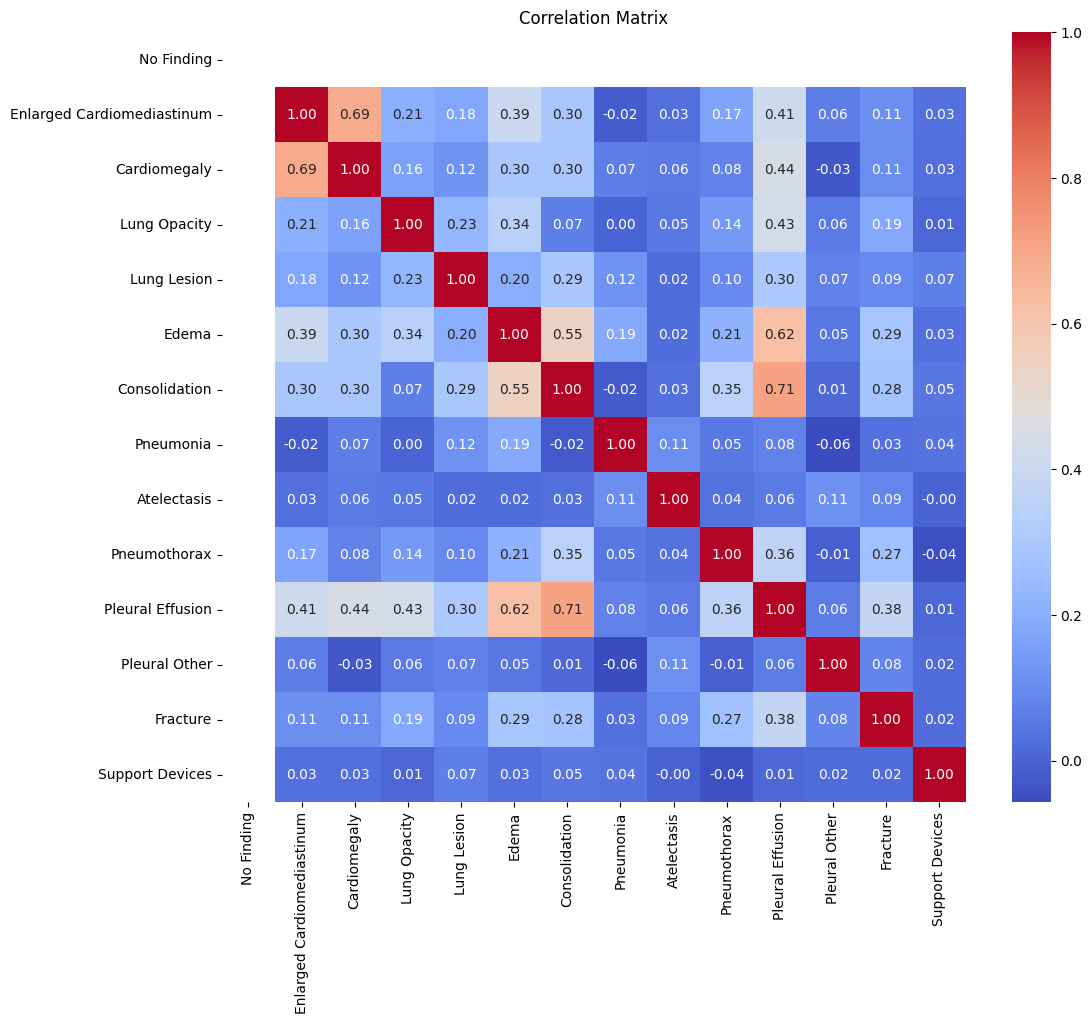

In [ ]:
import seaborn as sns

# Hitung korelasi antar kolom pada dataset train_df (hanya kolom numerik)
numeric_columns = train_df.select_dtypes(include=['number'])
correlation_table = numeric_columns.corr()

# Tampilkan tabel korelasi
print("Tabel Korelasi:")
import matplotlib.pyplot as plt

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

## MENYIAPKAN DATASET

### Membuat Data Test dari Data Valid

In [ ]:
# Bagi valid_df menjadi validasi dan test set
valid_df, test_df = train_test_split(valid_df, test_size=0.2, random_state=42)
print("valid_df menjadi validasi dan test set")

valid_df menjadi validasi dan test set


In [ ]:
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validasi: {len(valid_df)}")
print(f"Jumlah data test: {len(test_df)}\n")

Jumlah data train: 223414
Jumlah data validasi: 187
Jumlah data test: 47



=== Informasi Data Sampel ===

Label Penyakit:
Path: CheXpert-v1.0-small/train/patient35631/study6/view1_frontal.jpg
No Finding: nan
Enlarged Cardiomediastinum: nan
Cardiomegaly: nan
Lung Opacity: 1.0
Lung Lesion: nan
Edema: nan
Consolidation: 0.5
Pneumonia: nan
Atelectasis: 0.5
Pneumothorax: 1.0
Pleural Effusion: 1.0
Pleural Other: nan
Fracture: nan
Support Devices: 1.0


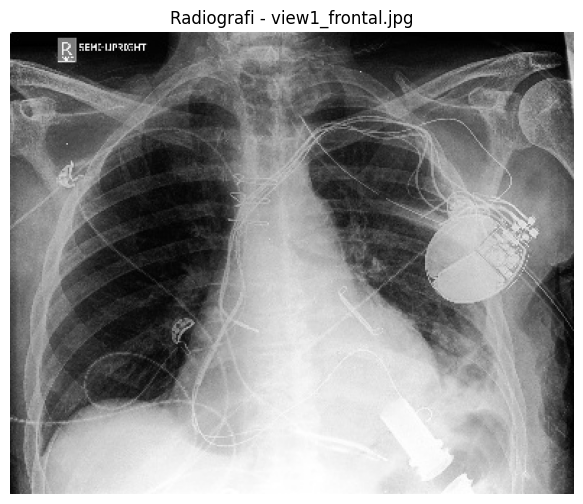

In [ ]:
# Pilih 1 sampel acak
random_sample = train_df.sample(1).iloc[0]

# Tampilkan informasi data
print("=== Informasi Data Sampel ===")
# print(f"Path: {random_sample['Path']}")
# print(f"Jenis Kelamin: {random_sample['Sex']}")
# print(f"Usia: {random_sample['Age']}")
# print(f"View: {random_sample['Frontal/Lateral']}")
print("\nLabel Penyakit:")
for col in train_df.columns[0:]:  # Kolom penyakit dimulai dari indeks 5
    print(f"{col}: {random_sample[col]}")

# Load dan tampilkan gambar
try:
    img_path = 'datasets/' + random_sample['Path']
    img = Image.open(img_path).convert('RGB')
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Radiografi - {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()
    
except FileNotFoundError:
    print(f"\nERROR: File tidak ditemukan di path: {img_path}")
    print("Pastikan:")
    print("1. Dataset gambar sudah di-download")
    print("2. Path relatif/absolut benar")
    print("3. Struktur folder sesuai dengan kolom 'Path'")
except Exception as e:
    print(f"\nERROR: {str(e)}")